In [3]:
using PyCall

In [4]:
using Plots

plotly()

┌ Info: For saving to png with the Plotly backend PlotlyBase has to be installed.
└ @ Plots /home/konira/.julia/packages/Plots/lW9ll/src/backends.jl:318


Plots.PlotlyBackend()

In [5]:
@pyimport vectorbt as vbt

In [6]:
dados_dia = vbt.BinanceData.download("MATICUSDT", start="2022-07-01",interval="1d").get()

/home/konira/.local/lib/python3.10/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)
2022-07-01 03:00:00+00:00 - 2022-09-02 00:00:00+00:00: : 1it [00:01,  1.04s/it]


,Open,High,Low,Close,Volume,Close time,Quote volume,Number of trades,Taker base volume,Taker quote volume
Open time,,,,,,,,,,
2022-07-02 00:00:00+00:00,0.4621,0.4963,0.4486,0.4930,183222500.6,2022-07-02 23:59:59.999000+00:00,8.585046e+07,180390,91563323.0,4.290912e+07
2022-07-03 00:00:00+00:00,0.4931,0.4942,0.4491,0.4621,170900076.3,2022-07-03 23:59:59.999000+00:00,8.045481e+07,200466,85517929.3,4.026771e+07
2022-07-04 00:00:00+00:00,0.4621,0.4953,0.4513,0.4918,166121678.0,2022-07-04 23:59:59.999000+00:00,7.818459e+07,189049,83822802.5,3.947073e+07
2022-07-05 00:00:00+00:00,0.4917,0.5355,0.4857,0.5127,335931980.8,2022-07-05 23:59:59.999000+00:00,1.719209e+08,412806,170009772.2,8.702289e+07
2022-07-06 00:00:00+00:00,0.5127,0.5308,0.4929,0.5257,242883092.8,2022-07-06 23:59:59.999000+00:00,1.248979e+08,303334,119640573.9,6.153892e+07
...,...,...,...,...,...,...,...,...,...,...
2022-08-29 00:00:00+00:00,0.7827,0.8211,0.7617,0.8168,102998979.9,2022-08-29 23:59:59.999000+00:00,8.176315e+07,253410,48681732.7,3.859919e+07
2022-08-30 00:00:00+00:00,0.8165,0.8441,0.7827,0.8153,85386455.6,2022-08-30 23:59:59.999000+00:00,6.964019e+07,204794,43733889.7,3.568159e+07
2022-08-31 00:00:00+00:00,0.8153,0.8567,0.8153,0.8323,80353318.7,2022-08-31 23:59:59.999000+00:00,6.692875e+07,214619,42434665.4,3.533760e+07


# Criando indicador MMA

# MA(V) = $\frac{\sum_{i=1}^{k} V_i}{k}$

# ou

# $MA(V,i,k) = \frac{\sum_{i}^{k} V_i}{1+(k-i)}$
$ \{i \in \mathbb{I} \; | \; i \geq 1\}$

$\{k \in \mathbb{I} \; | \; k \geq i\}$


In [43]:
∑ᵢᵏ = sum
MA(V) = ∑ᵢᵏ(V)/length(V)
MA(V,i,k) = i ≥ 1 && k ≥ i ? ∑ᵢᵏ(V[i:k])/(1+(k-i)) : missing

3.5

# $MMA(V,P) = reverse(R_{V_{r}})$

# $V_{r} = reverse(V)$

# $ R_{V_{r}} = [\;MA(V_{r},i,k)_{i=1},\, MA(V_{r},i,k)_{i=2},\, ..., \,MA(V_{r},i,k)_{i=n}\;]$

$ reverse(V) =  \{VR_{i}\}_{i=1}^{n},\,= V_{(n+1)-i} $

$k=i+P-1$

$k \in \mathbb{I} \,| \, 0 < k <= n $

$i \in \mathbb{I}\, | \, 1<i<=n $

$P \in \mathbb{I}\, |\, P > 0 $

In [1]:
MMA(V,P) =  [ K>=P && 0<P<=length(V) ? ∑ᵢᵏ(V[K-P+1:K])/P : missing for K ∈ 1:length(V)]

MMA (generic function with 1 method)

In [51]:
preco = dados_dia["Close"] .|> c -> c

58-element Vector{Float64}:
 0.493
 0.4621
 0.4918
 0.5127
 0.5257
 0.5628
 0.6059
 0.5899
 0.5717
 0.563
 0.5362
 0.6389
 0.7096
 ⋮
 0.8848
 0.857
 0.7695
 0.7863
 0.8205
 0.8099
 0.8322
 0.8136
 0.8183
 0.7651
 0.8049
 0.8102

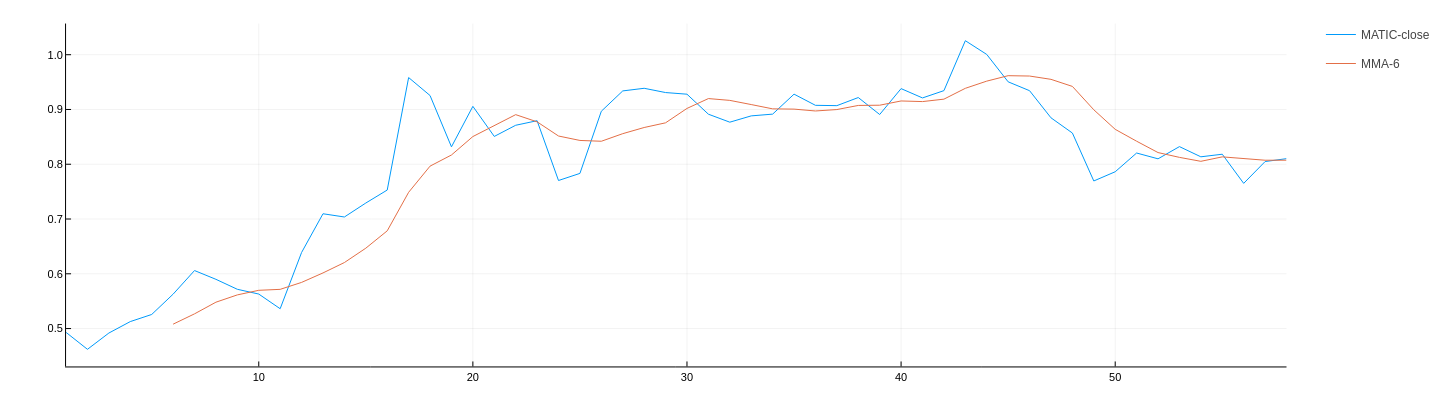

In [59]:
P=6
plot(preco,lab="MATIC-close")
plot!(MMA(preco,P),lab=string("MMA","-",P))

In [60]:
dados = dados_dia
prices = preco
//
media_rapida = vbt.MA.run(prices,window=P)
entradas  = media_rapida.ma_crossed_above(prices)
saidas = media_rapida.ma_crossed_below(prices)
//
portifolio = vbt.Portfolio.from_signals(close=prices, 
     entries=entradas, 
     exits=saidas, 
     fees=0.01, 
     freq="1d")
portifolio.stats()

PyObject Start                                        0
End                                         57
Period                        58 days 00:00:00
Start Value                              100.0
End Value                           120.686642
Total Return [%]                     20.686642
Benchmark Return [%]                 64.340771
Max Gross Exposure [%]                   100.0
Total Fees Paid                      16.921971
Max Drawdown [%]                     19.844167
Max Drawdown Duration         14 days 00:00:00
Total Trades                                 7
Total Closed Trades                          7
Total Open Trades                            0
Open Trade PnL                             0.0
Win Rate [%]                         85.714286
Best Trade [%]                       14.257951
Worst Trade [%]                      -14.32162
Avg Winning Trade [%]                 6.016889
Avg Losing Trade [%]                 -14.32162
Avg Winning Trade Duration     2 days 04:00:00
Avg 

In [61]:
portifolio.plot()

PyObject FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'dcacecd3-8839-421b-b102-47850035abbe',
              'x': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
                          18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
                          36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
                          54, 55, 56, 57], dtype=int64),
              'xaxis': 'x',
              'y': array([0.493 , 0.4621, 0.4918, 0.5127, 0.5257, 0.5628, 0.6059, 0.5899, 0.5717,
                          0.563 , 0.5362, 0.6389, 0.7096, 0.7037, 0.7292, 0.7529, 0.9583, 0.9255,
                          0.8318, 0.9057, 0.8508, 0.8712, 0.8795, 0.7703, 0.7833, 0.8968, 0.9339,
                          0.9387, 0.9309, 0.9279, 0.8914, 0.8768, 0.8883, 0.8915, 0.928 , 0.9076,
                          0.907 , 0.9218, 0.8908, 0.9381, 0.9211, 0.9344, 1.0256, 1.0005, 0.9505,
                          0.9343, 0.8848, 0.857 , 0.7695, 0.7863, 0.8205, 0.8099, 0.8322, 0.8136,
                          0.8183, 0.7651, 0.8049, 0.8102]),
              'yaxis': 'y'},
             {'customdata': array([[  0.        , 175.86128062,   0.99009901],
                                   [  2.        , 129.44624566,   1.10132866],
                                   [  4.        , 144.87025542,   1.11593558],
                                   [  6.        , 142.86176669,   1.27346979],
                                   [  8.        , 145.88062159,   1.29950458],
                                   [ 10.        , 141.12645768,   1.34140698],
                                   [ 12.        , 150.46371172,   1.15119786]]),
              'hovertemplate': ('Order Id: %{customdata[0]}<br>' ... '<br>Fees: %{customdata[2]:.6f}'),
              'legendgroup': '1',
              'marker': {'color': '#37B13F',
                         'line': {'color': 'rgb(38,123,44)', 'width': 1},
                         'size': 8,
                         'symbol': 'triangle-up'},
              'mode': 'markers',
              'name': 'Buy',
              'type': 'scatter',
              'uid': '2accd072-a812-4a26-b3e3-7c481d650e9f',
              'x': array([ 9, 20, 23, 30, 38, 44, 55], dtype=int64),
              'xaxis': 'x',
              'y': array([0.563 , 0.8508, 0.7703, 0.8914, 0.8908, 0.9505, 0.7651]),
              'yaxis': 'y'},
             {'customdata': array([[  1.        , 175.86128062,   1.12357772],
                                   [  3.        , 129.44624566,   1.13847973],
                                   [  5.        , 144.87025542,   1.29919645],
                                   [  7.        , 142.86176669,   1.32575719],
                                   [  9.        , 145.88062159,   1.36850611],
                                   [ 11.        , 141.12645768,   1.17445438],
                                   [ 13.        , 150.46371172,   1.21905699]]),
              'hovertemplate': ('Order Id: %{customdata[0]}<br>' ... '<br>Fees: %{customdata[2]:.6f}'),
              'legendgroup': '2',
              'marker': {'color': '#EA4335',
                         'line': {'color': 'rgb(181,31,18)', 'width': 1},
                         'size': 8,
                         'symbol': 'triangle-down'},
              'mode': 'markers',
              'name': 'Sell',
              'type': 'scatter',
              'uid': '9e393c2b-23f8-42e8-9534-b5b1cba27aef',
              'x': array([11, 22, 25, 34, 39, 52, 57], dtype=int64),
              'xaxis': 'x',
              'y': array([0.6389, 0.8795, 0.8968, 0.928 , 0.9381, 0.8322, 0.8102]),
              'yaxis': 'y'},
             {'customdata': array([[0.00000000e+00, 0.00000000e+00, 1.12341945e+01, 1.13465364e-01],
                                   [1.00000000e+0

In [17]:
[1,2,3] - (2*4 .- [1,1,1])

3-element Vector{Int64}:
 -6
 -5
 -4

In [18]:
∑ᵢᵏ = sum
SMA(V, P) = [ K>=P && 0<P<=length(V) ? ∑ᵢᵏ(V[K-P+1:K])/P : missing for K ∈ 1:length(V)]

SMA (generic function with 1 method)